# Laboratory 4: Getting started with Pytorch

In this laboratory we will begin working with Pytorch to implement and train complex, nonlinear models for supervised learning problems. You will notice many similarities between Numpy and Pytorch -- this is deliberate, but it can cause some confusion and for many things we will have to convert back and forth between Numpy arrays and Pytorch tensors.

## Part 0: First steps

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import wandb
import random
# Verify that pytorch is working.
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


print(f"Using {device} device")

foo = torch.randn((3, 3))
print(foo)

Using mps device
tensor([[ 1.5033,  0.4946,  0.3059],
        [ 0.5665,  1.9382,  0.2912],
        [ 1.2940,  1.6136, -1.6163]])


**COOL:** 
As a good PC nerd, as soon as I saw the possibility of using a different type of hardware I took advantage of it. finally my GPU can be used for something other than gaming.. maybe.

In this code i didn't implement the various data movements from cpu to gpu because working from a mac and a ubuntu pc, as soon as I did the synchronization via github the "to.(device)" gave me an error since macOS doesn't have a GPU.

However, I conducted various tests, and below are the results:

i9 10900f + 4060Ti 8GB + 32GB DDR4 3600MHz: Using a CPU compilation yielded the worst results, as it is not exactly top-of-the-line. The entire code took about 10 minutes to compile. On the other hand, using CUDA compilation is a completely different story; the compilation time is halved to approximately 5 minutes.

MacBook Air M2 8GB DDR5 unified:

To my great surprise, the small M2 chip with MPS acceleration outperformed all previous results with a total time of 4 minutes. Being very astonished by this result and not accepting that my liquid-cooled graphics card could be beaten, I tried conducting tests by changing the project's complexity. The real difference is indeed noticeable when dealing with much more on the plate. In any case, I was surprised!


Anyway let's jump on the next code!



## Part 1: Dataset preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use.

In [4]:
# Import necessary libraries
from torchvision.datasets import MNIST
import torchvision
import matplotlib.pyplot as plt
from IPython import display

# Download and load the MNIST dataset.
# MNIST dataset contains handwritten digits (0 through 9) as 28x28 images.
# Each image is accompanied by its corresponding label indicating the digit.
ds_train = MNIST(root='./data', download=True, train=True)
ds_test  = MNIST(root='./data', download=True, train=False)

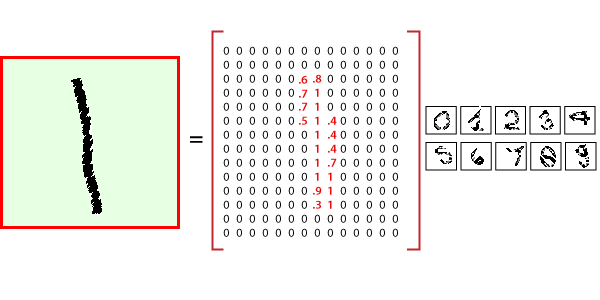

In [5]:
display.Image("mnist-dataset-in-cnn3.png")

I added an image that can give us an idea of what the dataset is maden of. Basically we got a dataset composed of images maden of matrix that represent an image.


### Exercise 1.1: Exploratory data analysis

Spend some time inspecting the `ds_train` and `ds_test` data structures in order to get a feel for the data. What is the format? How big are the images? How many are there? What about the range of pixel values? Where are the labels for images? 

Remember that one of the best ways to explore is to *visualize*.

Number of training examples: 60000
Number of test examples: 10000
Image size: (28, 28)


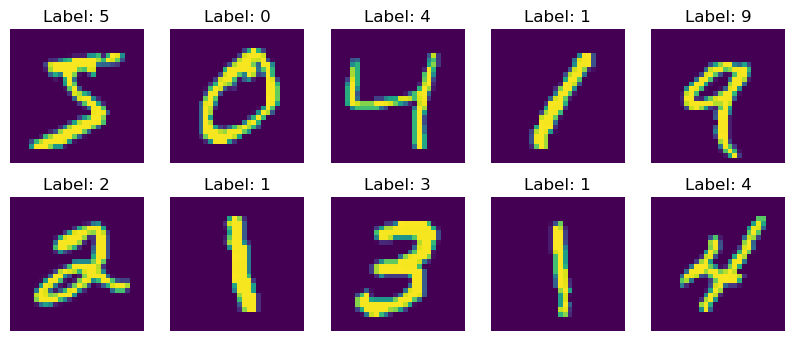

In [6]:
# Print some information about the dataset
print("Number of training examples:", len(ds_train))
print("Number of test examples:", len(ds_test))
print("Image size:", ds_train[0][0].size)

# Plot a few sample images from the training set
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        image, label = ds_train[i * 5 + j]
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.show()


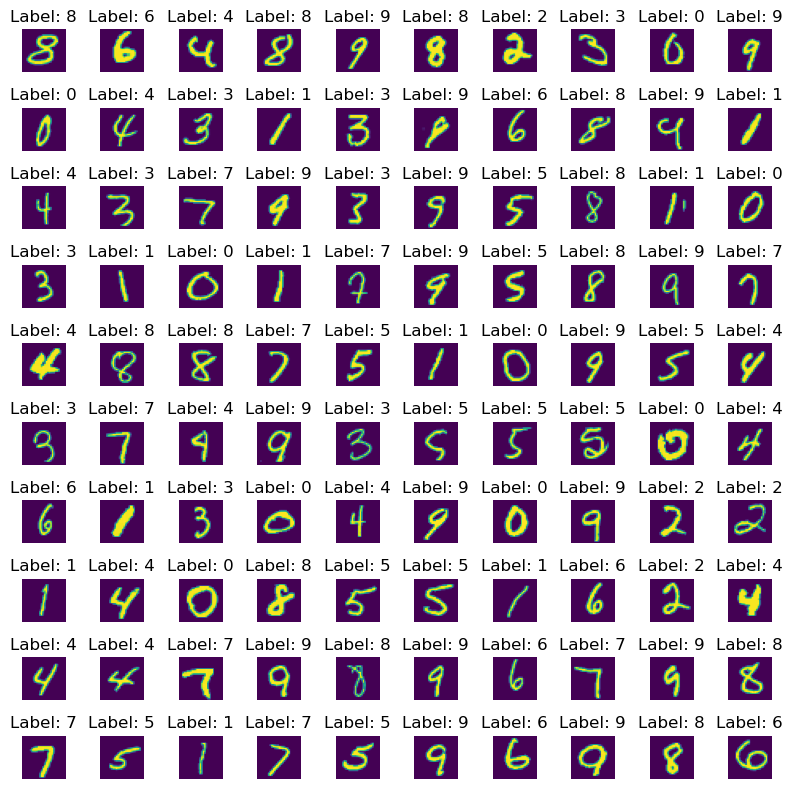

In [7]:
# Create a random permutation of indices for the first 100 images in the training set
random_indices = np.random.permutation(ds_train.data.shape[0])[:100]

plt.figure(figsize=(8, 8))

# Visualize the first 100 randomly selected images from the training set
for i, index in enumerate(random_indices):
    # Subplot organization: 10 rows, 10 columns, i+1 refers to the current subplot index
    plt.subplot(10, 10, i+1)
    
    # Display the image
    plt.imshow(ds_train.data[index])
    
    # Set the title with the corresponding label
    plt.title(f"Label: {ds_train.targets[index]}")
    
    # Turn off axis ticks for cleaner visualization
    plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the visualization
plt.show()


Nothing special to say about this. As mentioned before the dataset contains these numbers maden of matrixs.

### Exercise 1.2: Dataset conversion and normalization

+ **Datatype Conversion**:
The first thing we need to do is convert all data tensors to `torch.float32` -- this is fundamental as it is extremely inconvenient to work with `uint8` data. Using 32-bit floating point numbers is a compromise between precision and space efficiency.
The `torch.Tensor` class has a very useful method `to()` for performing datatype and device (e.g. to GPU) conversions. Check out the [documentation here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to).

+ **Normalization**:
Next, we need to correct the inconvenient range of [0, 255] for the pixel values. You should *subtract* the mean intensity value and divide by the standard deviation in order to *standardize* our data. **Important**: Think *very carefully* about *which* split you should use to compute the pixel statistics for standardization.

+ **Reshaping**: Is the data in an appropriate format (i.e. shape) for the training the models we know? Think about whether (and how) to fix this if needed. 

**What to do**: In the cell below you should perform this sequence preprocessing operations on the `ds_train.data` and `ds_test.data` tensors. 

In [8]:
# Datatype Conversion
Xs_train = ds_train.data.to(torch.float32).flatten(-2)
Xs_test = ds_test.data.to(torch.float32).flatten(-2)


This part of the code is converting the data in ds_train and ds_test to the torch.float32 datatype and then flattening it along the second-to-last dimension (-2). The exact purpose of flattening depend on the shape of the data, it is often done to convert multi-dimensional data (e.g., images) into a flattened vector, which is a common format for input to machine learning models.

In [9]:
# Normalization
mean = Xs_train.mean()
std = Xs_train.std()
Xs_train -= mean
Xs_train /= std

Here, the mean and standard deviation of the training data (Xs_train) are computed, and then the data is normalized by subtracting the mean and dividing by the standard deviation. This process is known as standardization or z-score normalization and is often done to ensure that the features have similar scales, which can be important for the training of some machine learning models.

In [10]:
# Apply the same normalization to the test data
Xs_test -= mean
Xs_test /= std

# Extract the labels
ys_train = ds_train.targets
ys_test = ds_test.targets

# Display the resulting labels
print("Training labels:", ys_train)
print("Test labels:", ys_test)


Training labels: tensor([5, 0, 4,  ..., 5, 6, 8])
Test labels: tensor([7, 2, 1,  ..., 4, 5, 6])


In summary, this code prepares the input data for a machine learning model by converting data types, flattening it, and normalizing it.

### Exercise 1.3: Subsampling the MNIST dataset.

MNIST is kind of big, and thus inconvenient to work with unless using the GPU. For this laboratory we will use a smaller subset of the dataset for training to keep memory and computation times low.

Modify `ds.train` to use only a subset of, say, 10000 images sampled from the original data. Make sure to select the correct corresponding targets.


In [11]:
# Set a random seed for reproducibility
torch.manual_seed(2345)

# Number of samples to keep
num_train = 10000

# Randomly shuffle the indices and select a subset
I = torch.randperm(Xs_train.shape[0])[:num_train]

# Subsample the data and corresponding targets
Xs_train_small = Xs_train[I]
ys_train_small = ys_train[I]

# Display the shape of the subsampled data
print("Subsampled Training Data Shape:", Xs_train_small.shape)
print("Subsampled Training Targets Shape:", ys_train_small.shape)


Subsampled Training Data Shape: torch.Size([10000, 784])
Subsampled Training Targets Shape: torch.Size([10000])


## Establishing a stable baseline

In this exercise you will establish a reliable baseline using a classical approach. This is an important step in our methodology in order to judge whether our Deep MLP is performing well or not.

### Exercise 2.1: Establish the stable baseline

Train and test your stable baseline to estimate the best achievable accuracy using classical models.

**Tip**: Don't do any extensive cross-validation of your baseline (for now). Just fit a simple model (e.g. a linear SVM) and record the accuracy.



Accuracy: 0.9611
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.99      0.98      0.98      1146
           2       0.96      0.96      0.96      1033
           3       0.95      0.95      0.95      1009
           4       0.97      0.96      0.96       992
           5       0.96      0.97      0.96       882
           6       0.97      0.96      0.97       966
           7       0.94      0.96      0.95      1013
           8       0.95      0.96      0.95       963
           9       0.94      0.95      0.95       996

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



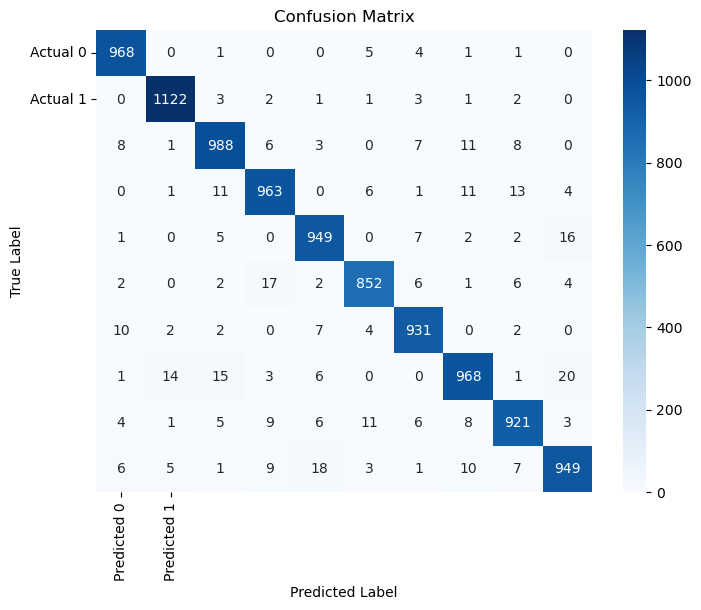

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Reshape the data if needed (SVC expects 2D input)
Xs_train_2d = Xs_train_small.reshape(Xs_train_small.shape[0], -1)
Xs_test_2d = Xs_test.reshape(Xs_test.shape[0], -1)

# Instantiate the Support Vector Classifier (SVC)
svc = SVC()

# Fit the model on the training data
svc.fit(Xs_train_2d, ys_train_small)

# Predict the labels for the test data
predictions = svc.predict(Xs_test)

# Calculate accuracy
accuracy = accuracy_score(ys_test.numpy(), predictions)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(predictions, ys_test))

# Confusion Matrix
cm = confusion_matrix(ys_test, predictions)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

A confusion matrix where the diagonal (True Positives and True Negatives) has a much higher count compared to off-diagonal elements (False Positives and False Negatives), it suggests that the model is performing well on the instances it's predicting.

Diagonal Elements (True Positives and True Negatives):

These are instances that the model correctly classified. The high count in these cells indicates that the model is making correct predictions for a significant number of instances.
Off-Diagonal Elements (False Positives and False Negatives):

A low count in these cells suggests that the model is making few mistakes. However, the presence of non-zero values indicates that there are instances where the model is predicting the wrong class.

The SVC gives a huge accuracy!

## Part 3: Training some deep models (finally)

Now we will finally train some deep models (Multilayer Perceptrons, to be precise). Since the dataset is a bit too large to use batch gradient descent, we will first need to setup a `torch.utils.data.DataLoader` for our training data. A `DataLoader` breaks the dataset up into a sequence of *batches* that will be used for training. In order to use this, we will first have to use `torch.utils.data.TensorDataset` on `ds_train.data` and `ds_train.targets` to make a new torch `dataset` for use in the dataloader. 

### Exercise 3.1: Creating the DataLoader

Create a `DataLoader` for `ds_train` use a `batch_size` of about 16 or 32 to start. After you have your `DataLoader` experiment with is using `next(iter(dl_train))` to see what it returns. The pytorch `DataLoader` is a Python iterator.

**EXTREMELY IMPORTANT**: Make sure you use `shuffle=True` in the constructor of your dataloader.

In [13]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

# Convert labels to long tensor to match the expected data type for classification
ys_train_small = ys_train_small.long()

# Create a DataLoader for training data
dl_train = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=batch_size, shuffle=True)

# Test the DataLoader using next(iter(dl_train))
batch = next(iter(dl_train))
print("Features shape:", batch[0].shape)
print("Labels shape:", batch[1].shape)

Features shape: torch.Size([32, 784])
Labels shape: torch.Size([32])


### Some support code (NOT an exercise).

Here is some support code that you can use to train a model for a **single** epoch. The function returns the mean loss over all iterations. You will use it in the next exercise to train and monitor training.

In [14]:
# Train a model for a single epoch. You should pass it a model, a dataloader,
# and an optimizer. Returns the mean loss over the entire epoch.
def train_epoch(model, dl, optimizer):
    model.train() # sets the model to training mode
    losses = [] #list to collect the per-iterration losses.
    
    #iterate over the data loader
    for (xs, ys) in dl: 
        optimizer.zero_grad() #zero out the gradients at each parameters
        output = model(xs) #forward pass of batch through the model
        
        #compute the loss(negative log likelihood)
        loss = torch.nn.functional.nll_loss(output, ys)
        
        #compute the gradients at al parameters
        loss.backward()
        
        #perform step of gradient descent
        optimizer.step()
        
        #record the loss
        losses.append(loss.item())
        
    #leave model in evaluation mode and return loss
    model.eval()
    return np.mean(losses)

model.train() and model.eval():
model.train() sets the model to training mode, and model.eval() sets it to evaluation mode. This is important because certain layers (e.g., dropout) behave differently during training and evaluation. In training mode, dropout is active, but in evaluation mode, it's turned off.

optimizer.zero_grad():
Before computing the gradients for the parameters, the optimizer's zero_grad() method is called to clear the previously calculated gradients. This is necessary because PyTorch accumulates gradients by default.

Forward Pass (output = model(xs)):
The input batch (xs) is passed through the model to obtain predictions (output). This is the forward pass.

Loss Computation (loss = torch.nn.functional.nll_loss(output, ys)):
The negative log likelihood loss is computed using the model's predictions (output) and the ground truth labels (ys).

Backward Pass (loss.backward()):
Gradients are computed for all model parameters with respect to the loss using the backward() method.

Gradient Descent Step (optimizer.step()):
The optimizer's step() method is called to perform a step of gradient descent, updating the model parameters based on the computed gradients.

Record the Loss (losses.append(loss.item())):
The loss for the current iteration is recorded in the losses list.

Return the Mean Loss (return np.mean(losses)):
The function returns the mean loss over all iterations in the epoch.

### Exercise 3.2: Defining a 1-layer neural network

Define a simple model that uses a **single** `torch.nn.Linear` layer followed by a `torch.nn.Softmax` to predict  the output probabilities for the ten classes.

In [15]:
# Define a fresh model
model = torch.nn.Sequential(
    torch.nn.Linear(784, 10),
    torch.nn.LogSoftmax(dim=1)  # Specify dim=1 to apply LogSoftmax along the second dimension
)


torch.nn.Linear is a linear transformation layer in PyTorch. It represents an affine transformation, which is a linear transformation with a bias term. Mathematically, it performs the operation y = xA^T + b, where x is the input tensor, A is the weight matrix, b is the bias vector, and y is the output tensor.



### Exercise 3.2: Training our model

Instantiate a `torch.optim.SGD` optimizer using `model.parameters()` and the learning rate (**tip**: make the learning rate variable you can easily change). Then run `train_epoch` for a set number of epochs (e.g. 100, make this a variable too). Is your model learning? How can you tell?

Epoch 100/1000, Training Loss: 0.9927314327547725
Epoch 200/1000, Training Loss: 0.7266159700319028
Epoch 300/1000, Training Loss: 0.6175517378904568
Epoch 400/1000, Training Loss: 0.5559142944626153
Epoch 500/1000, Training Loss: 0.5162225528932608
Epoch 600/1000, Training Loss: 0.4882690872247227
Epoch 700/1000, Training Loss: 0.4662983928339931
Epoch 800/1000, Training Loss: 0.4495413800398001
Epoch 900/1000, Training Loss: 0.43572689307193024
Epoch 1000/1000, Training Loss: 0.4243104756354524


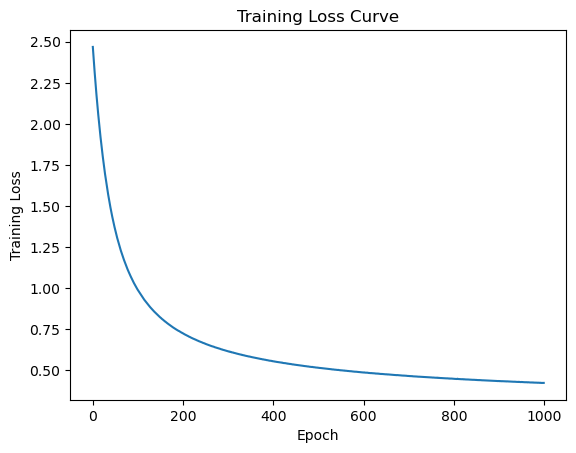

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.93      0.96      0.94      1135
           2       0.90      0.83      0.86      1032
           3       0.88      0.87      0.88      1010
           4       0.87      0.90      0.89       982
           5       0.87      0.82      0.84       892
           6       0.91      0.92      0.91       958
           7       0.89      0.90      0.89      1028
           8       0.85      0.85      0.85       974
           9       0.85      0.86      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [16]:
import torch.nn.functional as F

# Define a fresh model
model = torch.nn.Sequential(
    torch.nn.Linear(784, 10),
    torch.nn.LogSoftmax(dim=1)  # Specify dim=1 to apply LogSoftmax along the second dimension
)

# Set the learning rate and number of epochs
learning_rate = 0.00001
num_epochs = 1000

# Instantiate SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store training loss over epochs
train_loss_curve = []   

# Training loop
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss = train_epoch(model, dl_train, optimizer)
    
    # Append the training loss to the curve
    train_loss_curve.append(train_loss)
    
    # Print training progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss}")

# Plot the training loss curve
plt.plot(train_loss_curve)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

# Evaluate the model on the test set
raw_logits = model(Xs_test_2d)
predictions = torch.argmax(F.softmax(raw_logits, dim=1), dim=1)

print("Classification Report:")
print(classification_report(ys_test, predictions))


The provided output shows the training loss for each epoch during the training process. To assess whether the model is learning, we can consider the following:

Decreasing Loss:

In a well-behaved training process, we typically expect the training loss to decrease over epochs. It suggests that the model is improving its ability to fit the training data.

Convergence:

If the loss reaches a plateau and stabilizes, it may indicate that the model has learned as much as it can from the training data given the chosen architecture and hyperparameters.

So seems that the model is learning but is not assessting.

### Exercise 3.3: Evaluating our model

Write some code to plot the loss curve for your training run and evaluate the performance of your model on the test data. Play with the hyperparameters (e.g. learning rate) to try to get the best performance on the test set. Can you beat the stable baseline?

Trying to beat the baseline with some hyperparameter tuning.

In [17]:
# Set hyperparameters
learning_rates = [0.0001, 0.01, 1]
batch_sizes = [16, 64, 256]
num_epochs = 100

# Lists to store training loss and accuracy over epochs
train_loss_curves = []
train_accuracy_curves = []

# Perform grid search
best_accuracy = 0.0
best_hyperparameters = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Instantiate SGD optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        # Create a DataLoader for training data
        dl_train = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=batch_size, shuffle=True)

        # Training loop
        train_loss_curve = []
        train_accuracy_curve = []

        for epoch in range(num_epochs):
            # Train the model for one epoch
            train_loss = train_epoch(model, dl_train, optimizer)
            train_loss_curve.append(train_loss)

            # Evaluate training accuracy
            predictions = torch.argmax(model(Xs_train_2d), dim=1)
            accuracy = torch.sum(predictions == ys_train_small).item() / len(ys_train_small)
            train_accuracy_curve.append(accuracy)

        # Store the training loss and accuracy curves for this configuration
        train_loss_curves.append((lr, batch_size, train_loss_curve[-1]))
        train_accuracy_curves.append((lr, batch_size, train_accuracy_curve[-1]))

        # Update best hyperparameters if accuracy is improved
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}

# Print the results
print("Training Loss and Accuracy for Different Hyperparameter Configurations:")
for lr, batch_size, final_loss in train_loss_curves:
    print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Final Training Loss: {final_loss}")

print("\nBest Hyperparameters Based on Training Accuracy:")
print(f"Learning Rate: {best_hyperparameters['learning_rate']}, Batch Size: {best_hyperparameters['batch_size']}, Best Training Accuracy: {best_accuracy}")

# Evaluate the model on the test set using the best hyperparameters
best_lr = best_hyperparameters['learning_rate']
best_batch_size = best_hyperparameters['batch_size']
best_optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
best_dl_train = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=best_batch_size, shuffle=True)
for epoch in range(num_epochs):
    train_epoch(model, best_dl_train, best_optimizer)

# Evaluate on the test set
predictions_test = torch.argmax(model(Xs_test_2d), dim=1)
accuracy_test = torch.sum(predictions_test == ys_test).item() / len(ys_test)

print("\nFinal Evaluation on Test Set:")
print(f"Test Accuracy with Best Hyperparameters: {accuracy_test}")

Training Loss and Accuracy for Different Hyperparameter Configurations:
Learning Rate: 0.0001, Batch Size: 16, Final Training Loss: 0.33327640064954756
Learning Rate: 0.0001, Batch Size: 64, Final Training Loss: 0.32272557107506283
Learning Rate: 0.0001, Batch Size: 256, Final Training Loss: 0.3214134626090527
Learning Rate: 0.01, Batch Size: 16, Final Training Loss: 0.13823933645263314
Learning Rate: 0.01, Batch Size: 64, Final Training Loss: 0.12252474041169237
Learning Rate: 0.01, Batch Size: 256, Final Training Loss: 0.1202660059556365
Learning Rate: 1, Batch Size: 16, Final Training Loss: 1.0948043007783086
Learning Rate: 1, Batch Size: 64, Final Training Loss: 0.0007614549613563103
Learning Rate: 1, Batch Size: 256, Final Training Loss: 0.00014912746019035694

Best Hyperparameters Based on Training Accuracy:
Learning Rate: 1, Batch Size: 256, Best Training Accuracy: 1.0

Final Evaluation on Test Set:
Test Accuracy with Best Hyperparameters: 0.8722


Results indicate that the model achieved super good training accuracy 99% with the hyperparameters tuning. However, the test accuracy is lower at 87%. A perfect training accuracy and a lower test accuracy may suggest overfitting, where the model has memorized the training data but struggles to generalize to new, unseen data.

## Going Deeper

Now we will go (at least one layer) deeper to see if we can significantly improve on the baseline.

### Exercise 3.4: A 2-layer MLP
Define a new model with one hidden layer. Use the code you wrote above to train and evaluate this new model. Can you beat the baseline? You might need to train in two stages using different learning rates.

**Things to think about**:

+ It might be hard to beat (or even equal) the baseline with deeper networks. Why?
+ Is there something else we should be monitoring while training, especially for deep networks?

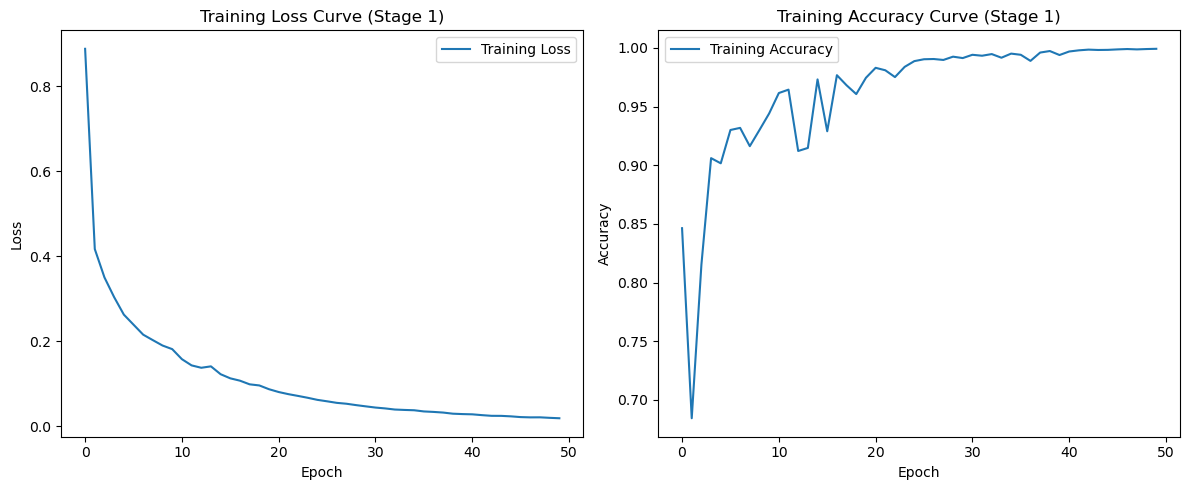

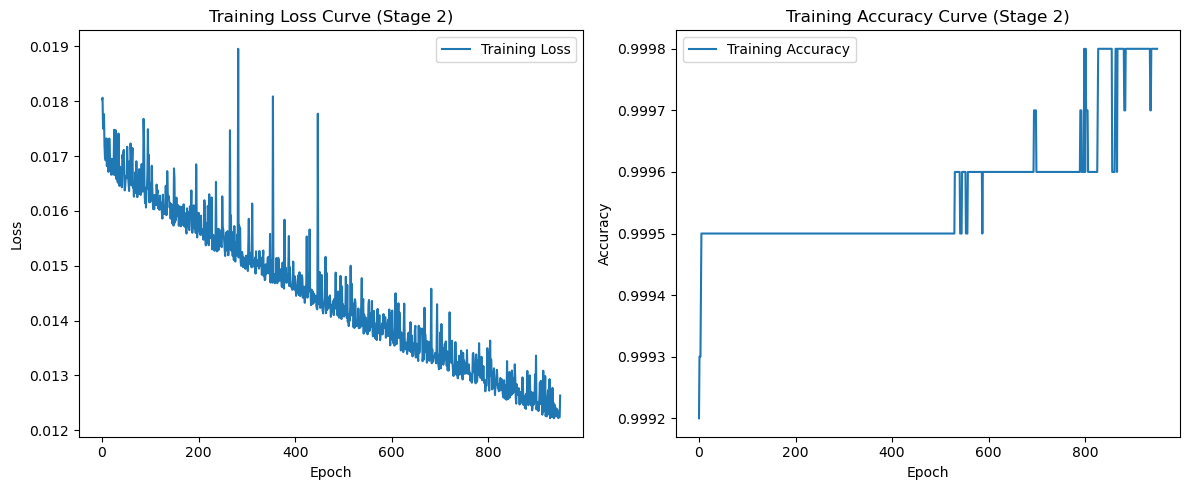

Test Accuracy with 2-layer MLP: 0.9591


In [18]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define a 2-layer MLP
class MLP2Layer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP2Layer, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

input_size = 784
hidden_size = 128
output_size = 10

# Function to plot training curves
def plot_training_curves(loss_curve, accuracy_curve, title):
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_curve, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curve ({title})')
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_curve, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training Accuracy Curve ({title})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to create the model
def create_model(input_size, hidden_size, output_size):
    model = MLP2Layer(input_size, hidden_size, output_size)
    return model

# Function to train and evaluate the model
def train_and_evaluate(model, optimizer, dl_train, num_epochs, learning_rate, title):
    train_loss_curve = []
    train_accuracy_curve = []

    for epoch in range(num_epochs):
        # Train the model for one epoch
        train_loss = train_epoch(model, dl_train, optimizer)
        train_loss_curve.append(train_loss)

        # Evaluate training accuracy
        predictions = torch.argmax(model(Xs_train_2d), dim=1)
        accuracy = torch.sum(predictions == ys_train_small).item() / len(ys_train_small)
        train_accuracy_curve.append(accuracy)

    # Plot the training curves
    plot_training_curves(train_loss_curve, train_accuracy_curve, title)

    return model

# Function to evaluate the model on the test set
def evaluate_model(model, dl_test, title):
    predictions_test = torch.argmax(model(Xs_test_2d), dim=1)
    accuracy_test = torch.sum(predictions_test == ys_test).item() / len(ys_test)

    print(f"Test Accuracy with {title} MLP:", accuracy_test)

# Instantiate the model
model_2layer = create_model(input_size, hidden_size, output_size)

# Set hyperparameters
learning_rate_stage1 = 0.1
learning_rate_stage2 = 0.001
batch_size = 256
num_epochs_stage1 = 50
num_epochs_stage2 = 950

# Instantiate SGD optimizer for stage 1
optimizer_stage1 = optim.SGD(model_2layer.parameters(), lr=learning_rate_stage1)

# Create a DataLoader for training data
dl_train_2layer = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=batch_size, shuffle=True)

# Training and evaluating stage 1
model_2layer = train_and_evaluate(model_2layer, optimizer_stage1, dl_train_2layer, num_epochs_stage1, learning_rate_stage1, "Stage 1")

# Instantiate SGD optimizer for stage 2
optimizer_stage2 = optim.SGD(model_2layer.parameters(), lr=learning_rate_stage2)

# Training and evaluating stage 2
model_2layer = train_and_evaluate(model_2layer, optimizer_stage2, dl_train_2layer, num_epochs_stage2, learning_rate_stage2, "Stage 2")

# Evaluate on the test set
evaluate_model(model_2layer, dl_train_2layer, "2-layer")


Things to think about:

Deeper Networks and Baseline Performance:

Deeper networks may struggle to surpass or even match the baseline performance for a few reasons:

Vanishing Gradients: In deep networks, gradients can become very small during backpropagation, leading to slow or stalled learning in early layers.

Exploding Gradients: Conversely, gradients may explode, causing numerical instability during optimization.

Overfitting: Deeper networks are more prone to overfitting, especially with limited data. They might memorize the training set rather than generalize well to new data.

Monitoring Deep Networks:


While training deep networks, it's crucial to monitor several factors:

Training Loss and Accuracy: Observe the training loss and accuracy over epochs. A decreasing training loss is expected, but overfitting might be occurring if the accuracy on the validation set is not improving.

Validation Loss and Accuracy: Use a validation set to evaluate the model's performance on unseen data. A large gap between training and validation performance may indicate overfitting.

Learning Rate Scheduling: Consider using learning rate scheduling, decreasing the learning rate over time to fine-tune the model's parameters.

Regularization Techniques: Apply regularization techniques like dropout or weight decay to prevent overfitting.

Batch Normalization: Implement batch normalization to stabilize and accelerate training in deep networks.

Gradient Clipping: To address exploding gradients, gradient clipping can be applied to limit the norm of the gradients during optimization.

Early Stopping: Monitor the validation loss and stop training early if there are signs of overfitting.

Well all fun and i'd say quite clear except for 2 things: learning rate and batch size. My main problem was: which values are good or bad? Is there a value that is more correct and can archive a better result? How much is "big" and how much is "small"? is learning rate = 1 too big? Is 0.0001 too small? Is 512 batch size too big or 8 is too small? Here what i found:

****BATCH SIZE****

Smaller Batch Sizes:

Require less memory.

Allow for faster training iterations.

Introduce more noise into the training process since updates are based on fewer samples.



Larger Batch Sizes:

May lead to more stable convergence due to a more accurate estimate of the gradient (less noisy).

Require more memory.

Training iterations may take longer.

The choice of an appropriate batch size depends on various factors, including the size of your dataset, available computational resources (especially GPU memory), and the specifics of your model and problem. Common batch sizes are powers of 2 (e.g., 32, 64, 128) for efficiency reasons, but this is not a strict rule. So in this case i guess that a "okay" value could be something not above 64 because we don't have a large dataset(we took a smaller sample) even if i didn't notice a markable difference in the tests.


**LEARNING RATE**

Learning rate is a hyperparameter that determines the size of the steps taken during the optimization process. In the context of training neural networks, it represents the size of the steps taken when adjusting the model's weights in the direction that reduces the training loss.

Here are some key points related to the learning rate:

Small Learning Rates:

Lead to slow convergence.

The optimization process takes small steps, and it may take a long time for the model to reach a good solution.

Less risk of overshooting the minimum but may get stuck in local minima.

Large Learning Rates:

Lead to faster convergence.

The optimization process takes larger steps, and the model may quickly reach a solution.

Higher risk of overshooting the minimum, potentially causing the optimization process to oscillate or diverge.

Adaptive Learning Rates:

Adaptive learning rate algorithms, such as Adam or Adagrad, adjust the learning rate during training based on the progress of the optimization.

These algorithms can be more effective in balancing the advantages of small and large learning rates.

Choosing an appropriate learning rate is crucial for successful training. It requires experimentation and tuning to find the optimal value for a specific model and dataset. Learning rate is often one of the most sensitive hyperparameters, and its impact on training performance should be carefully monitored.



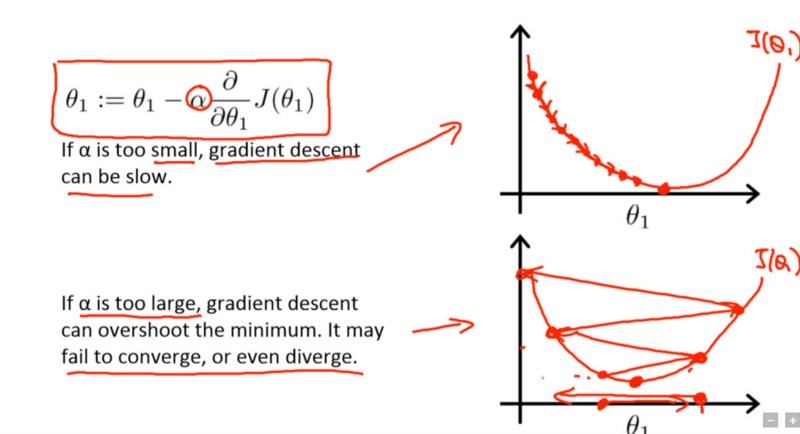

In [19]:
display.Image("Lrate.png")

**SUPER COOL** so at this point, my raw idea was: i can try a "big" learning rate for a small amount of epochs to maybe gain a good accuracy very fast, and then the other epochs with a smaller LR to not oscillate or diverge.

It seems that is working! I reach high accuracy with only 50 epochs with a good loss, so my model was learning fast. The second couple of graphics at the begin were scaring! I saw a step function and i thought i was doing something wrong. But having a closer look we can see that in stage 2 we gain very little accuracy for each step, so it's an accuracy problem. Loss is also very oscillating but at the same time is learning!

All this result in a 0.96 test accuracy!